# Recht op Lucht - kalibratie passieve samplers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn
seaborn.set_theme(style="whitegrid")
seaborn.set_context("poster")

In [2]:
data = pd.read_csv("../data/rol_measurements_calibration.csv")

In [3]:
# take average of duplo measurements
data = data.groupby(["location", "period"]).mean().reset_index()

In [4]:
data

,location,period,no2,no2_reference,missing
0,VMM Belgiëlei,2,29.5,31.017345,2.356406
1,VMM Belgiëlei,3,33.5,33.081413,2.398801
2,VMM Belgiëlei,4,28.0,30.273599,2.305476
3,VMM Belgiëlei,5,25.0,22.898928,3.115727
4,VMM Belgiëlei,6,20.5,24.107692,13.075780
5,VMM Belgiëlei,7,25.0,23.996148,3.134328
6,VMM Belgiëlei,8,19.5,18.221198,2.544910
7,VMM Belgiëlei,9,24.0,24.160235,11.703704
8,VMM Belgiëlei,10,29.5,27.493921,2.083333
9,VMM Belgiëlei,11,31.5,31.946154,2.840060


## Overview data

In [5]:
def overview_comparison(data):
    meas = data["no2"]
    ref = data["no2_reference"]
    
    print(f"Bias: {meas.mean() - ref.mean():.2f} µg/m³")
    print(f"MAD:   {(meas - ref).abs().mean():.2f} µg/m³")

Using all data:

In [6]:
overview_comparison(data)

Bias: -1.74 µg/m³
MAD:   2.28 µg/m³


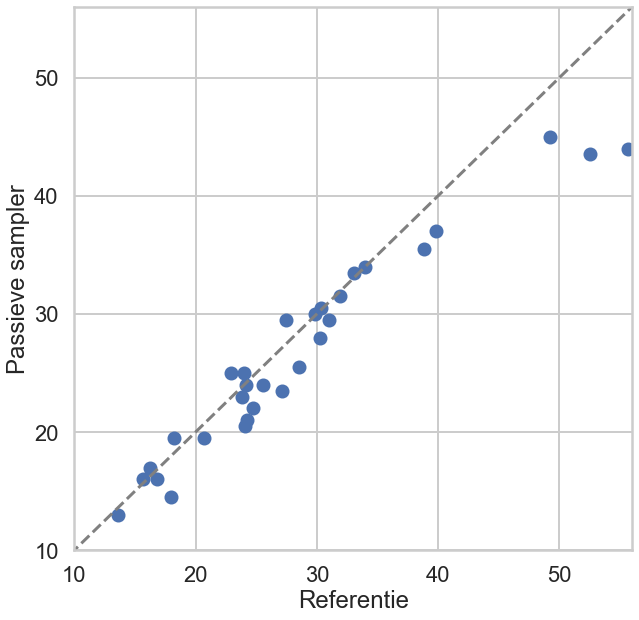

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data["no2_reference"], data["no2"])
ax.plot([0, 56], [0, 56], color="grey", linestyle="--")
ax.set(xlim=(10, 56), ylim=(10, 56), xlabel="Referentie", ylabel="Passieve sampler");

In [8]:
data2 = data[data["missing"] < 25]

In [9]:
overview_comparison(data2)

Bias: -1.03 µg/m³
MAD:   1.64 µg/m³


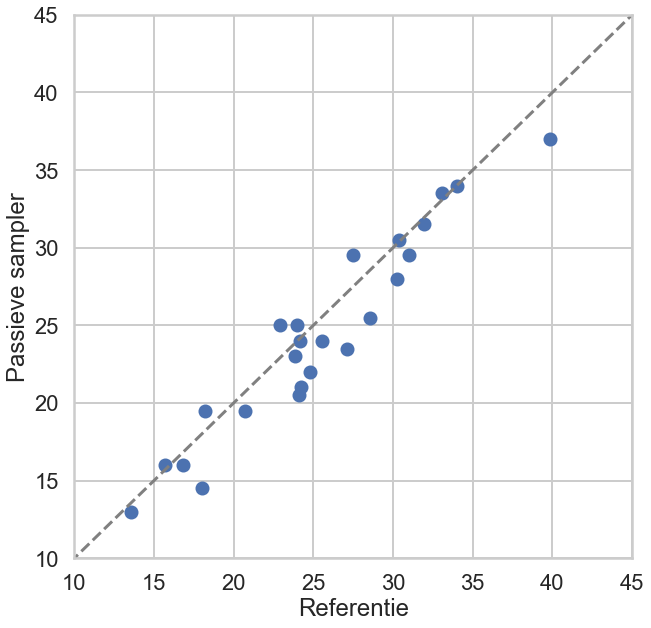

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data2["no2_reference"], data2["no2"])
ax.plot([0, 45], [0, 45], color="grey", linestyle="--")
ax.set(xlim=(10, 45), ylim=(10, 45), xlabel="Referentie", ylabel="Passieve sampler");

In [11]:
data3 = data[(data["location"] != "Van Maerlant") & (data["missing"] < 25)]

In [12]:
overview_comparison(data3)

Bias: -0.96 µg/m³
MAD:   1.59 µg/m³


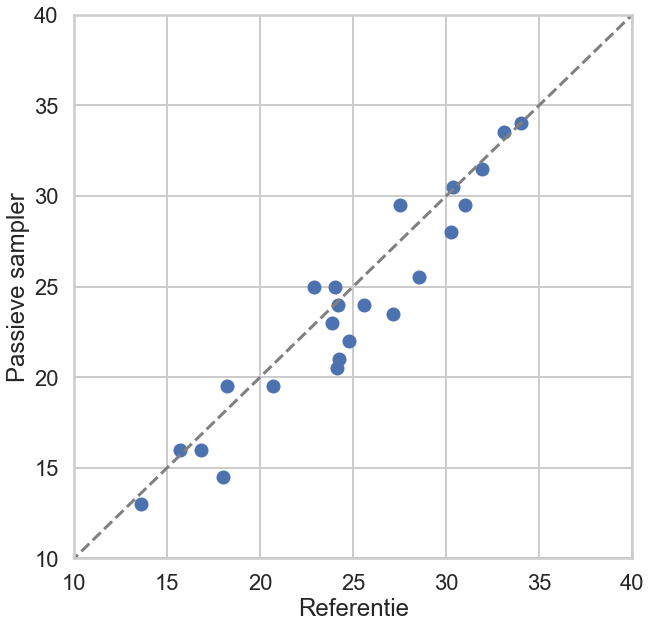

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data3["no2_reference"], data3["no2"])
ax.plot([0, 40], [0, 40], color="grey", linestyle="--")
ax.set(xlim=(10, 40), ylim=(10, 40), xlabel="Referentie", ylabel="Passieve sampler");

## Kalibratie

Met een orthogonale regressie:

In [14]:
from scipy.odr import Model, Data, ODR

In [15]:
def linear_regression(P, x):
    """Linear function y = m*x + b"""
    return P[0]*x + P[1]

Using all data:

In [16]:
linear = Model(linear_regression)

x = data['no2_reference'].values
y = data['no2'].values

mydata = Data(x, y)
myodr = ODR(mydata, linear, beta0=[1., 0.])

myoutput = myodr.run()
slope, intercept = myoutput.beta

myoutput.pprint()

Beta: [0.82346646 3.27896703]
Beta Std Error: [0.03892709 1.17558249]
Beta Covariance: [[ 0.00053672 -0.01525442]
 [-0.01525442  0.48949376]]
Residual Variance: 2.823313175974995
Inverse Condition #: 0.0011171346940039688
Reason(s) for Halting:
  Sum of squares convergence


In [17]:
a = 1/slope
b = -intercept/slope
print(f"NO2_gekalibreerd = {a:.3f} x NO2_sampler + {b:.3f}")

NO2_gekalibreerd = 1.214 x NO2_sampler + -3.982


Using data <25% missing:

In [18]:
linear = Model(linear_regression)

x = data2['no2_reference'].values
y = data2['no2'].values

mydata = Data(x, y)
myodr = ODR(mydata, linear, beta0=[1., 0.])

myoutput = myodr.run()
slope, intercept = myoutput.beta

myoutput.pprint()

Beta: [ 1.00440393 -1.14630334]
Beta Std Error: [0.06039266 1.5804028 ]
Beta Covariance: [[ 0.00219607 -0.05584645]
 [-0.05584645  1.50388373]]
Residual Variance: 1.6608152236017908
Inverse Condition #: 0.0008989895073514838
Reason(s) for Halting:
  Sum of squares convergence


In [19]:
a = 1/slope
b = -intercept/slope
print(f"NO2_gekalibreerd = {a:.3f} x NO2_sampler + {b:.3f}")

NO2_gekalibreerd = 0.996 x NO2_sampler + 1.141


In [20]:
data2 = data[data["missing"] < 25]
data2_cal = data2.copy()
data2_cal["no2"] = data2_cal["no2"] * a + b

In [21]:
overview_comparison(data2_cal)

Bias: -0.00 µg/m³
MAD:   1.48 µg/m³


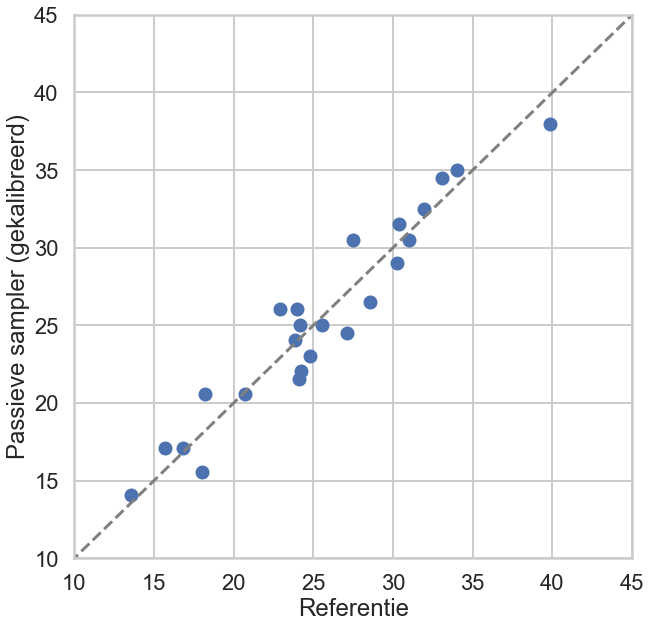

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(data2_cal["no2_reference"], data2_cal["no2"])
ax.plot([0, 45], [0, 45], color="grey", linestyle="--")
ax.set(xlim=(10, 45), ylim=(10, 45), xlabel="Referentie", ylabel="Passieve sampler (gekalibreerd)");